In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import tensorflow as tf
import keras
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import category_encoders as ce # i imported this for encoding the categorical/object variables

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('generated_two.csv')
display(df.head()) # display the first 5 rows of the dataset
display(df.tail()) # display the last 5 rows of the dataset

,Time,Day,Temp,Humidity,Light_Intensity,Occupancy,Energy
0,07:00,Sunday,21.2,63.2,295,0,3.79
1,07:20,Sunday,22.0,61.5,245,0,3.61
2,07:40,Sunday,21.2,63.7,326,0,3.55
3,08:00,Sunday,22.8,59.2,275,0,3.98
4,08:20,Sunday,22.4,59.2,323,0,4.03


,Time,Day,Temp,Humidity,Light_Intensity,Occupancy,Energy
1995,00:00,Sunday,13.6,77.2,5,0,4.87
1996,00:20,Sunday,14.5,73.8,2,0,4.14
1997,00:40,Sunday,14.5,76.7,8,0,3.76
1998,01:00,Sunday,14.6,75.7,6,0,5.10
1999,01:20,Sunday,15.5,74.0,8,0,4.63


In [3]:
df.shape

(2000, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             2000 non-null   object 
 1   Day              2000 non-null   object 
 2   Temp             2000 non-null   float64
 3   Humidity         2000 non-null   float64
 4   Light_Intensity  2000 non-null   int64  
 5   Occupancy        2000 non-null   int64  
 6   Energy           2000 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 109.5+ KB


In [5]:
df['Occupancy'].value_counts(normalize=True)

Occupancy
0    0.702
1    0.298
Name: proportion, dtype: float64

In [6]:
df.describe()

,Temp,Humidity,Light_Intensity,Occupancy,Energy
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,20.033550,59.912500,252.529500,0.298000,7.126735
std,3.817697,8.069426,316.731801,0.457494,2.483395
min,12.400000,40.400000,0.000000,0.000000,2.730000
25%,16.900000,53.600000,5.000000,0.000000,5.200000
50%,20.050000,59.700000,9.000000,0.000000,6.460000
75%,23.200000,66.300000,499.250000,1.000000,8.855000
max,27.700000,78.100000,1258.000000,1.000000,14.610000


# Preparing data

In [7]:
# I converted time to a numerical feature (minutes since midnight)
df['Minutes'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour * 60 + pd.to_datetime(df['Time'], format='%H:%M').dt.minute

df['Minutes']

0       420
1       440
2       460
3       480
4       500
       ... 
1995      0
1996     20
1997     40
1998     60
1999     80
Name: Minutes, Length: 2000, dtype: int32

In [8]:
df.columns

Index(['Time', 'Day', 'Temp', 'Humidity', 'Light_Intensity', 'Occupancy',
       'Energy', 'Minutes'],
      dtype='object')

In [9]:
# Define features and target
features_to_use = ['Minutes', 'Temp', 'Humidity', 'Light_Intensity', 'Occupancy']
X = df[features_to_use]
y = df['Energy']

# Initialize Target Encoder from category encoders
target_encoder = ce.TargetEncoder(cols=['Day'])

X['Day'] = target_encoder.fit_transform(df['Day'], y)

In [10]:
# df = pd.get_dummies(df, columns=['Day'])

# features_to_use = ['Minutes', 'Temp', 'Humidity', 'Light_Intensity', 'Occupancy'] + [col for col in df.columns if col.startswith('Day_')]
# X = df[features_to_use].values
# y = df['Energy'].values

In [11]:
# display X
X.head()

,Minutes,Temp,Humidity,Light_Intensity,Occupancy,Day
0,420,21.2,63.2,295,0,4.926949
1,440,22.0,61.5,245,0,4.926949
2,460,21.2,63.7,326,0,4.926949
3,480,22.8,59.2,275,0,4.926949
4,500,22.4,59.2,323,0,4.926949


In [12]:
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X.values)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

In [13]:
print('The scaled features have {} rows and {} columns'.format(X_scaled.shape[0], X_scaled.shape[1]))
print()
print('The scaled target variable has {} rows and {} columns'.format(y_scaled.shape[0], y_scaled.shape[1]))

The scaled features have 2000 rows and 6 columns

The scaled target variable has 2000 rows and 1 columns


# building the LSTM model

In [14]:
# Function to create sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 9 # Define sequence length (3 hours = 9 timestamps)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length) # Create sequences for features and target

In [15]:
# Split into training and testing sets (80-20 split)
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [84]:
################################################### LSTM model Architecture ###################################################

# model = Sequential([
#     LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[1])),
#     Dropout(0.2),
#     LSTM(64, activation='relu'),
#     Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dense(1)
# ])


model = Sequential([
    LSTM(256, activation='relu', return_sequences=True, input_shape=(seq_length, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

c:\Users\Dell\anaconda3\envs\raqib\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [85]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Compile the model

In [86]:
model.compile(optimizer='adam', loss='mse')  # Compile the model


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)   # early stopping to prevent overfitting


# model training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
history

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 0.1132 - val_loss: 0.0175
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0279 - val_loss: 0.0243
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0226 - val_loss: 0.0127
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0195 - val_loss: 0.0124
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0181 - val_loss: 0.0147
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0179 - val_loss: 0.0129
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0165 - val_loss: 0.0150
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0159 - val_loss: 0.0132
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0160 - val_loss: 0.0133
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0166 - val_loss: 0.0191
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0151 - val_loss: 0.0143
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/st

In [106]:
# Evaluate the model
results = model.evaluate(X_test, y_test, verbose=0)
results

0.01058256532996893

In [107]:
y_pred_scaled = model.predict(X_test)  ################## making predictions ##################

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


In [109]:
######################## also, inverse transform predictions and actual values #######################
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_actual = target_scaler.inverse_transform(y_test)

# evaluating the LSTM model

In [121]:
mse = mean_squared_error(y_test_actual, y_pred)
rmse = root_mean_squared_error(y_test_actual, y_pred)
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100


print("\nModel Performance Metrics:")
print(f"Root Mean Square Error: {rmse:.2f} kWh")
print(f"Mean Absolute Error: {mae:.2f} kWh")
print(f"R-squared Score: {r2:.3f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Model Performance Metrics:
Root Mean Square Error: 1.22 kWh
Mean Absolute Error: 0.98 kWh
R-squared Score: 0.680
Mean Absolute Percentage Error: 15.06%


In [115]:
y.describe()

count    2000.000000
mean        7.126735
std         2.483395
min         2.730000
25%         5.200000
50%         6.460000
75%         8.855000
max        14.610000
Name: Energy, dtype: float64

#### **1. Root Mean Square Error (RMSE): 1.22 kWh**
- The RMSE represents the average error between predicted and actual energy values. 
- Considering the target variable has a **mean of 7.13 kWh** and a **standard deviation of 2.48 kWh**, an error of **1.22 kWh** is moderate. It’s less than half of the standard deviation, which means the model is reasonably good at capturing the variability in energy consumption.

#### **2. Mean Absolute Error (MAE): 0.98 kWh**
- The MAE (0.98 kWh) suggests the model’s predictions are, on average, off by about **14% of the mean energy value (7.13 kWh)**.
- This level of error is acceptable for many practical scenarios, especially in cases where small deviations in energy predictions don’t significantly affect outcomes.

#### **3. R-squared Score (R²): 0.680**
- With **68% of variance explained**, the model is performing decently. However, it still leaves **32% of variability** unexplained, which might be addressed by better features, architecture, or additional training data.

#### **4. Mean Absolute Percentage Error (MAPE): 15.06%**
- A 15% error suggests that, on average, the model’s predictions deviate from actual values by this percentage. 
- Considering the descriptive stats, this level of error is reasonable but could be better if you aim for higher precision.

---

Given the target variable ranges between **2.73 kWh** and **14.61 kWh**, the model’s error metrics are **practical for general predictions** but **not ideal for tasks requiring high accuracy.** For instance:
- If predicting energy to allocate resources, this is fine.
- If exact energy usage matters for billing or optimization, this model might need refinement.

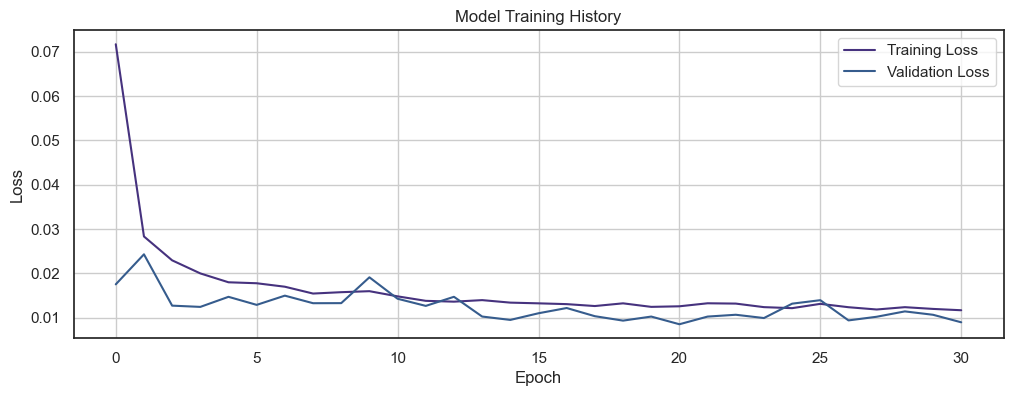

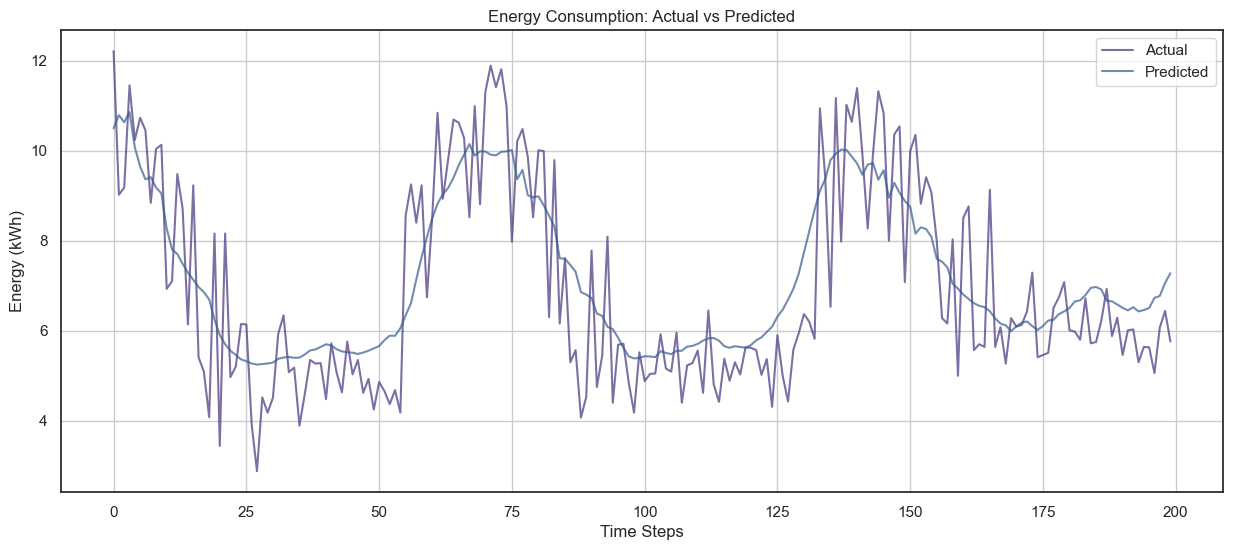

In [116]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(y_test_actual, y_pred, num_points=200):
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_actual[:num_points], label='Actual', alpha=0.7)
    plt.plot(y_pred[:num_points], label='Predicted', alpha=0.7)
    plt.title('Energy Consumption: Actual vs Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Energy (kWh)')
    plt.legend()
    plt.grid(True)
    plt.show()




plot_training_history(history)
plot_predictions(y_test_actual, y_pred)

In [117]:
print("Let's see further Analysis and predicton Interval:")
print(f"Average Actual Energy Consumption: {np.mean(y_test_actual):.2f} kWh")
print(f"Average Predicted Energy Consumption: {np.mean(y_pred):.2f} kWh")
print(f"Standard Deviation of Actual Values: {np.std(y_test_actual):.2f} kWh")
print(f"Standard Deviation of Predicted Values: {np.std(y_pred):.2f} kWh")

residuals = y_test_actual - y_pred
prediction_std = np.std(residuals)
confidence_interval = 1.96 * prediction_std  # 95% confidence interval
print(f"\nPrediction Interval (95% confidence): ±{confidence_interval:.2f} kWh")

Let's see further Analysis and predicton Interval:
Average Actual Energy Consumption: 6.99 kWh
Average Predicted Energy Consumption: 7.02 kWh
Standard Deviation of Actual Values: 2.16 kWh
Standard Deviation of Predicted Values: 1.63 kWh

Prediction Interval (95% confidence): ±2.39 kWh


# Saving the LSTM model

In [122]:
print('###################### saving the LSTM Model #########################')

keras.saving.save_model(model=model, filepath='second_model.keras')
print("\nModel saved as 'second_model.keras'")

###################### saving the LSTM Model #########################

Model saved as 'second_model.keras'


# Making Inferences

In [16]:
# i imported the saved model to start with

model = load_model('second_model.keras')
print(model.input_shape)

(None, 9, 6)


In [17]:
def preprocess_and_predict(model, user_input, feature_scaler, target_scaler, target_encoder):
    """
    Preprocess user input with target encoding and predict energy using the trained LSTM model.

    Args:
    - model: Trained LSTM model.
    - user_input: Dictionary with user inputs for raw features.
    - feature_scaler: Fitted MinMaxScaler for feature scaling.
    - target_scaler: Fitted MinMaxScaler for target scaling.
    - target_encoder: Fitted TargetEncoder for encoding categorical features.

    Returns:
    - Predicted energy value (inverse scaled).
    """
    
    
    input_df = pd.DataFrame([user_input])

    # Convert Time to "Minutes since midnight"
    input_df['Minutes'] = pd.to_datetime(input_df['Time'], format='%H:%M').dt.hour * 60 + pd.to_datetime(input_df['Time'], format='%H:%M').dt.minute

    # Drop the original 'Time' column
    input_df = input_df.drop(columns=['Time'])

    # Target encode the 'Day' column
    input_df['Day'] = target_encoder.transform(input_df['Day'])
    
    feature_order = ['Minutes', 'Temp', 'Humidity', 'Light_Intensity', 'Occupancy', 'Day']
    input_df = input_df[feature_order]

    # Scale features
    scaled_features = feature_scaler.transform(input_df)
    scaled_features = scaled_features.reshape(1, 1, -1)

    # Make & Inverse scale the prediction
    scaled_prediction = model.predict(scaled_features)

    predicted_energy = target_scaler.inverse_transform(scaled_prediction)[0][0]
    return predicted_energy



print("Enter the following details:")
time = input("Time (e.g., 09:30, 14:00): ")
day = input("Day (e.g., Monday, Tuesday): ")
temp = float(input("Temperature (°C) (between 15.00 and 35.00): "))
humidity = float(input("Humidity (%): "))
light_intensity = float(input("Light Intensity (0 to 1000): "))
occupancy = int(input("Occupancy (0 or 1): "))


user_input = {
    "Time": time,
    "Day": day,
    "Temp": temp,
    "Humidity": humidity,
    "Light_Intensity": light_intensity,
    "Occupancy": occupancy
}


predicted_energy = preprocess_and_predict(model, user_input, feature_scaler, target_scaler, target_encoder)
print(f"\nPredicted Energy: {predicted_energy:.2f} kWh")

Enter the following details:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Predicted Energy: 4.69 kWh
